In [1]:
import numpy as np
import pickle as pkl
from scipy import integrate, optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
from sklearn import svm
import sympy

In [2]:
mpl.rc('font',**{'family':'serif','serif':['Times']})
mpl.rc('font',**{'size':18})
mpl.rc('text', usetex=True)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{calrsfs} \DeclareMathAlphabet{\pazocal}{OMS}{zplm}{m}{n}'

# Minimal model of tumor-immune ecosystem

In [3]:
def ode_model(N, params, absolute = False):   
    T, P, A = N
    rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega\
    = [params[key] for key in 'rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega'.split(', ')]
    
    dTdt = T * (rT - (rT / KT) * T + alphaTP * P - alphaTA * A)
    dPdt = P * (- dP * P + alphaPT * T) + omega * A * T
    dAdt = A * (rA - (rA / KA) * A + alphaAT * T - alphaAP * P) - omega * A * T
    derivs = np.array([dTdt, dPdt, dAdt])
    
    return derivs

In [4]:
def Jacobian(N, params):   
    T, P, A = N
    rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega\
    = [params[key] for key in 'rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega'.split(', ')]
        
    J = np.array([[rT - 2 * (rT / KT) * T + alphaTP * P - alphaTA * A, alphaTP * T, -alphaTA * T],\
                  [alphaPT * P + omega * A, - 2 * dP * P + alphaPT * T, omega * T],\
                  [(alphaAT - omega) * A, -alphaAP * A, rA - 2 * (rA / KA) * A + (alphaAT - omega) * T - alphaAP * P]])
    
    return J

In [5]:
def generate_params(ranges):
    rT_range,KT_range,dP_range,rA_range,KA_range,alphaTP_range,alphaTA_range,alphaPT_range,alphaAT_range,alphaAP_range,omega_range = ranges
    
    rT = rT_range[0] + np.random.rand() * (rT_range[1] - rT_range[0])
    KT = KT_range[0] + np.random.rand() * (KT_range[1] - KT_range[0])
    dP = dP_range[0] + np.random.rand() * (dP_range[1] - dP_range[0])
    rA = rA_range[0] + np.random.rand() * (rA_range[1] - rA_range[0])
    KA = KA_range[0] + np.random.rand() * (KA_range[1] - KA_range[0])
    alphaTP = alphaTP_range[0] + np.random.rand() * (alphaTP_range[1] - alphaTP_range[0])
    alphaTA = alphaTA_range[0] + np.random.rand() * (alphaTA_range[1] - alphaTA_range[0])
    alphaPT = alphaPT_range[0] + np.random.rand() * (alphaPT_range[1] - alphaPT_range[0])
    alphaAT = alphaAT_range[0] + np.random.rand() * (alphaAT_range[1] - alphaAT_range[0])
    alphaAP = alphaAP_range[0] + np.random.rand() * (alphaAP_range[1] - alphaAP_range[0])
    omega = omega_range[0] + np.random.rand() * (omega_range[1] - omega_range[0])
    
    params = {}
    keys_vals = zip('rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega'.split(', '),\
                    [rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega])
    for key, val in keys_vals:
        params[key] = val
    
    return params

In [6]:
def all_solutions(params, check = True, tol = 1e-7):
    rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega\
    = [params[key] for key in 'rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega'.split(', ')]
    
    def check_stable_feasible(N, params):
        J = Jacobian(N, params)
        l, v = np.linalg.eig(J)
        stable = np.all(np.real(l) <= 0)
        feasible = np.all(N >= 0)
        return stable, feasible
    
    solutions = {}
    
    # I) Tumor-only
    
    solutions['T'] = {}
    
    N = np.array([KT, 0 , 0])
    stable, feasible = check_stable_feasible(N, params)
    
    solutions['T']['N'] = [N]
    solutions['T']['stable'] = [stable]
    solutions['T']['feasible'] = [feasible]
    
    # II) ATI-only
    
    solutions['A'] = {}
    
    N = np.array([0, 0 , KA])
    stable, feasible = check_stable_feasible(N, params)
    
    solutions['A']['N'] = [N]
    solutions['A']['stable'] = [stable]
    solutions['A']['feasible'] = [feasible]
    
    # III) Tumor-ATI coexistence
    
    solutions['TA'] = {}
    
    if omega == 0:
        
        OmegaAT = rA + alphaAT * KT
        GammaAA = (rA / KA) + (alphaAT * alphaTA) / (rT / KT)
        N = np.array([KT - (KT * alphaTA / rT) * OmegaAT / GammaAA, 0, OmegaAT / GammaAA])
        stable, feasible = check_stable_feasible(N, params)
    
        solutions['TA']['N'] = [N]
        solutions['TA']['stable'] = [stable]
        solutions['TA']['feasible'] = [feasible]
        
    else:
        
        solutions['TA']['N'] = []
        solutions['TA']['stable'] = []
        solutions['TA']['feasible'] = []
    
    # IV) Tumor-PTI coexistence
    
    solutions['TP'] = {}
    
    GammaTT = (rT / KT) - (alphaTP * alphaPT / dP)
    N = np.array([rT / GammaTT, (alphaPT / dP) * (rT / GammaTT), 0])
    stable, feasible = check_stable_feasible(N, params)
    
    solutions['TP']['N'] = [N]
    solutions['TP']['stable'] = [stable]
    solutions['TP']['feasible'] = [feasible]
    
    # Tumor-PTI-ATI coexistence
    
    solutions['TPA'] = {}
    
    C1 = (rA * (rT / KT) + rT * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
    C2 = (alphaAP * (rT / KT) - alphaTP * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
    C3 = alphaTP * KT / rT
    C4 = alphaTA * KT / rT
    a = (C3 + C2 * C4) * (alphaPT - omega * C2) - dP
    b = (KT - C1 * C4) * (alphaPT - omega * C2) + omega * C1 * (C3 + C2 * C4)
    c = omega * C1 * (KT - C1 * C4)
    
    if b ** 2 - 4 * a * c < 0:
        
        solutions['TPA']['N'] = []
        solutions['TPA']['stable'] = []
        solutions['TPA']['feasible'] = []
    
    elif b ** 2 - 4 * a * c == 0:
        
        P = - b / (2 * a)
        A = C1 - C2 * P
        T = KT + C3 * P - C4 * A
        N = np.array([T, P, A])
        stable, feasible = check_stable_feasible(N, params)
        
        solutions['TPA']['N'] = [N]
        solutions['TPA']['stable'] = [stable]
        solutions['TPA']['feasible'] = [feasible]
    
    elif b ** 2 - 4 * a * c > 0:
        
        P1 = (- b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
        A1 = C1 - C2 * P1
        T1 = KT + C3 * P1 - C4 * A1
        N1 = np.array([T1, P1, A1])
        stable1, feasible1 = check_stable_feasible(N1, params)
        
        P2 = (- b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
        A2 = C1 - C2 * P2
        T2 = KT + C3 * P2 - C4 * A2
        N2 = np.array([T2, P2, A2])
        stable2, feasible2 = check_stable_feasible(N2, params)
        
        if (N1[0] >= N2[0]):
            solutions['TPA']['N'] = [N1, N2]
            solutions['TPA']['stable'] = [stable1, stable2]
            solutions['TPA']['feasible'] = [feasible1, feasible2]
        if (N1[0] < N2[0]):
            solutions['TPA']['N'] = [N2, N1]
            solutions['TPA']['stable'] = [stable2, stable1]
            solutions['TPA']['feasible'] = [feasible2, feasible1]
            
    
    # Check consistency of solutions with original equations
    
    if check == True:
        for key in solutions.keys():
            for N in solutions[key]['N']:
                if np.any(np.abs(ode_model(N, params)) > tol):
                    print("Warning: Check the %s solution."%key)
    
    return solutions

In [7]:
def coexistence_bifurcation_point(omega, params):
    rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, dummy\
    = [params[key] for key in 'rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega'.split(', ')]
    
    C1 = (rA * (rT / KT) + rT * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
    C2 = (alphaAP * (rT / KT) - alphaTP * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
    C3 = alphaTP * KT / rT
    C4 = alphaTA * KT / rT
    a = (C3 + C2 * C4) * (alphaPT - omega * C2) - dP
    b = (KT - C1 * C4) * (alphaPT - omega * C2) + omega * C1 * (C3 + C2 * C4)
    c = omega * C1 * (KT - C1 * C4)
    
    return b ** 2 - 4 * a * c

In [8]:
def bifurcation(bif_param, bif_param_vals, params):
    if bif_param not in params.keys():
        raise ValueError("This is an invalid bifurcation parameter.")
        
    if isinstance(bif_param_vals, list):
        bif_param_vals = np.array(bif_param_vals)
    elif isinstance(bif_param_vals, np.ndarray):
        bif_param_vals = bif_param_vals.flatten()
    else:
        raise ValueError("\'bif_param_vals\' should be a list or numpy array.")
        
    bif_params = {}
    for key in params.keys():
        bif_params[key] = params[key]
    
    results = {}
    results['bifurcation parameter'] = bif_param
    results['bifurcation parameter values'] = bif_param_vals
    results['T'] = {'N':[], 'stable':[], 'feasible':[]}
    results['A'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TA'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TP'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TPA1'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TPA2'] = {'N':[], 'stable':[], 'feasible':[]}
    
    for n, bp in enumerate(bif_param_vals):
        bif_params[bif_param] = bp
        sols = all_solutions(bif_params)
        
        results['T']['N'].append([bp] + list(sols['T']['N'][0]))
        results['T']['stable'].append([bp, sols['T']['stable'][0]])
        results['T']['feasible'].append([bp, sols['T']['feasible'][0]])
        
        results['A']['N'].append([bp] + list(sols['A']['N'][0]))
        results['A']['stable'].append([bp, sols['A']['stable'][0]])
        results['A']['feasible'].append([bp, sols['A']['feasible'][0]])
            
        if len(sols['TA']['N']) == 0:
            results['TA']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TA']['stable'].append([bp, np.nan])
            results['TA']['feasible'].append([bp, np.nan])
        else:
            results['TA']['N'].append([bp] + list(sols['TA']['N'][0]))
            results['TA']['stable'].append([bp, sols['TA']['stable'][0]])
            results['TA']['feasible'].append([bp, sols['TA']['feasible'][0]])
        
        results['TP']['N'].append([bp] + list(sols['TP']['N'][0]))
        results['TP']['stable'].append([bp, sols['TP']['stable'][0]])
        results['TP']['feasible'].append([bp, sols['TP']['feasible'][0]])
        
        if len(sols['TPA']['N']) == 0:
            results['TPA1']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA1']['stable'].append([bp, np.nan])
            results['TPA1']['feasible'].append([bp, np.nan])
            results['TPA2']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA2']['stable'].append([bp, np.nan])
            results['TPA2']['feasible'].append([bp, np.nan])
        elif len(sols['TPA']['N']) == 1:
            results['TPA1']['N'].append([bp] + list(sols['TPA']['N'][0]))
            results['TPA1']['stable'].append([bp, sols['TPA']['stable'][0]])
            results['TPA1']['feasible'].append([bp, sols['TPA']['feasible'][0]])
            results['TPA2']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA2']['stable'].append([bp, np.nan])
            results['TPA2']['feasible'].append([bp, np.nan])
        elif len(sols['TPA']['N']) == 2:
            s1 = np.argmax([sols['TPA']['N'][0][0], sols['TPA']['N'][1][0]])
            s2 = int(list(set([0,1]) - set([s1]))[0])
            results['TPA1']['N'].append([bp] + list(sols['TPA']['N'][s1]))
            results['TPA1']['stable'].append([bp, sols['TPA']['stable'][s1]])
            results['TPA1']['feasible'].append([bp, sols['TPA']['feasible'][s1]])
            results['TPA2']['N'].append([bp] + list(sols['TPA']['N'][s2]))
            results['TPA2']['stable'].append([bp, sols['TPA']['stable'][s2]])
            results['TPA2']['feasible'].append([bp, sols['TPA']['feasible'][s2]])
    
    for state in ['T', 'A', 'TA', 'TP', 'TPA1', 'TPA2']:
        results[state]['N'] = np.vstack(results[state]['N'])
        results[state]['stable'] = np.vstack(results[state]['stable'])
        results[state]['feasible'] = np.vstack(results[state]['feasible'])
        
    return results

In [9]:
def plot_bifurcation(ax, bifurcation_results, xlims = None, ylims = None, include_T = False, include_TA = False, C_map = None):
    if C_map is None:
        C = {'T':'C5','A':'C0','TA':'C6','TP':'C1','TPA1':'C2','TPA2':'C3'}
    else:
        C = C_map
        for state in ['T','A','TA','TP','TPA1','TPA2']:
            if state not in C.keys():
                raise ValueError("Some states are missing from the color map.")
    
    def plot_stability(state, ax):
        stable_and_feasible = np.where((bifurcation_results[state]['stable'][:,1] == 1) * (bifurcation_results[state]['feasible'][:,1] == 1))[0]
        unstable_and_feasible = np.where((bifurcation_results[state]['stable'][:,1] == 0) * (bifurcation_results[state]['feasible'][:,1] == 1))[0]
        
        if (stable_and_feasible.shape[0] > 0) and (unstable_and_feasible.shape[0] == 0):
            ax[0].plot(bifurcation_results[state]['N'][stable_and_feasible,0], bifurcation_results[state]['N'][stable_and_feasible,1],c=C[state],linewidth=2)
            ax[1].plot(bifurcation_results[state]['N'][stable_and_feasible,0], bifurcation_results[state]['N'][stable_and_feasible,2],c=C[state],linewidth=2)
            ax[2].plot(bifurcation_results[state]['N'][stable_and_feasible,0], bifurcation_results[state]['N'][stable_and_feasible,3],c=C[state],linewidth=2)
        elif (stable_and_feasible.shape[0] == 0) and (unstable_and_feasible.shape[0] > 0):
            ax[0].plot(bifurcation_results[state]['N'][unstable_and_feasible,0], bifurcation_results[state]['N'][unstable_and_feasible,1],'--',c=C[state],linewidth=2)
            ax[1].plot(bifurcation_results[state]['N'][unstable_and_feasible,0], bifurcation_results[state]['N'][unstable_and_feasible,2],'--',c=C[state],linewidth=2)
            ax[2].plot(bifurcation_results[state]['N'][unstable_and_feasible,0], bifurcation_results[state]['N'][unstable_and_feasible,3],'--',c=C[state],linewidth=2)
        
        else:
            stable_and_feasible = np.where((bifurcation_results[state]['stable'][:,1] == 1) * (bifurcation_results[state]['feasible'][:,1] == 1))[0]
            unstable_and_feasible = np.where((bifurcation_results[state]['stable'][:,1] == 0) * (bifurcation_results[state]['feasible'][:,1] == 1))[0]
            stable_indices = [np.min(stable_and_feasible),\
                              np.max(stable_and_feasible)]
            unstable_indices = [np.min(unstable_and_feasible),\
                                np.max(unstable_and_feasible)]
            if np.min(stable_indices) < np.min(unstable_indices):
                stable_indices = stable_indices + [np.min(unstable_indices)]
            elif np.min(stable_indices) > np.min(unstable_indices):
                unstable_indices = unstable_indices + [np.min(stable_indices)]
            
            ax[0].plot(bifurcation_results[state]['N'][stable_indices,0], bifurcation_results[state]['N'][stable_indices,1],c=C[state],linewidth=2)
            ax[1].plot(bifurcation_results[state]['N'][stable_indices,0], bifurcation_results[state]['N'][stable_indices,2],c=C[state],linewidth=2)
            ax[2].plot(bifurcation_results[state]['N'][stable_indices,0], bifurcation_results[state]['N'][stable_indices,3],c=C[state],linewidth=2)
            
            ax[0].plot(bifurcation_results[state]['N'][unstable_indices,0], bifurcation_results[state]['N'][unstable_indices,1],'--',c=C[state],linewidth=2)
            ax[1].plot(bifurcation_results[state]['N'][unstable_indices,0], bifurcation_results[state]['N'][unstable_indices,2],'--',c=C[state],linewidth=2)
            ax[2].plot(bifurcation_results[state]['N'][unstable_indices,0], bifurcation_results[state]['N'][unstable_indices,3],'--',c=C[state],linewidth=2)
    
    # Plot T solution
    
    if include_T == True:
        plot_stability('T',ax)
    
    # Plot A solution
    plot_stability('A', ax)
    
    # Plot TA solution
    if include_TA == True:
        plot_stability('TA', ax)
    
    # Plot TP solution
    plot_stability('TP', ax)
    
    # Plot TPA1 solution
    plot_stability('TPA1', ax)
    
    # Plot A solution
    plot_stability('TPA2', ax)
    
    if xlims != None:
        for n, a in enumerate(ax.flatten()):
            a.set_xlim(xlims[n])
        
    if ylims != None:
        for n, a in enumerate(ax.flatten()):
            a.set_ylim(ylims[n])

# Produce Figure 2

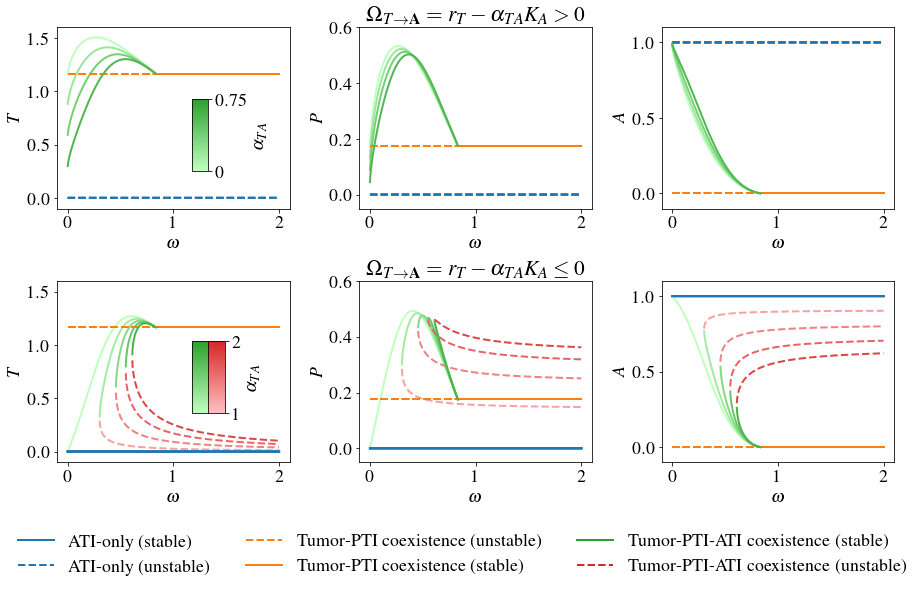

In [10]:
C2_RGB = mpl.colors.to_rgb('C2')
cdict = {'red':   [(0.0,  0.75, 0.75),
                   (1.0,  C2_RGB[0], C2_RGB[0])],

         'green': [(0.0,  1.0, 1.0),
                   (1.0, C2_RGB[1], C2_RGB[1])],

         'blue':  [(0.0,  0.75, 0.75),
                   (1.0,  C2_RGB[2], C2_RGB[2])]}
green2green = LinearSegmentedColormap('green2green', segmentdata=cdict, N=256)

C3_RGB = mpl.colors.to_rgb('C3')
cdict = {'red':   [(0.0,  1.0, 1.0),
                   (1.0,  C3_RGB[0], C3_RGB[0])],

         'green': [(0.0,  0.75, 0.75),
                   (1.0, C3_RGB[1], C3_RGB[1])],

         'blue':  [(0.0,  0.75, 0.75),
                   (1.0,  C3_RGB[2], C3_RGB[2])]}
red2red = LinearSegmentedColormap('red2red', segmentdata=cdict, N=256)

params_example = {}
params_example['rT'] = 1
params_example['KT'] = 1
params_example['dP'] = 1
params_example['rA'] = 1
params_example['KA'] = 1
params_example['alphaTP'] = .95
params_example['alphaTA'] = 1.5
params_example['alphaPT'] = .15
params_example['alphaAT'] = .05
params_example['alphaAP'] = .5
params_example['omega'] = 0

f, ax = plt.subplots(2,3,figsize=(15,8))

ax[0,0].set_ylabel(r'$T$')
ax[0,1].set_ylabel(r'$P$')
ax[0,2].set_ylabel(r'$A$')
ax[0,2].set_yticks([0,.5,1])
ax[1,0].set_ylabel(r'$T$')
ax[1,1].set_ylabel(r'$P$')
ax[1,2].set_ylabel(r'$A$')
ax[1,2].set_yticks([0,.5,1])
for a in ax.flatten():
    a.set_xlabel(r'$\omega$')

alphaTA_vals1 = [0,.25,.5,.75]
n = 0
N = float(len(alphaTA_vals1))
for alphaTA in alphaTA_vals1:
    params_example['alphaTA'] = alphaTA
    bif_results = bifurcation('omega', np.linspace(0,2,num=2000), params_example)
    C = {'T':'C5','A':'C0','TA':'C6','TP':'C1'}
    C['TPA1'] = green2green(n / N)
    C['TPA2'] = red2red(n / N)
    plot_bifurcation(ax[0], bif_results, ylims = [[-.1,1.6],[-.05,.6],[-.1,1.1]],C_map=C)
    n += 1

alphaTA_vals2 = [1,1.25,1.5,1.75,2]
n = 0
N = float(len(alphaTA_vals2))
for alphaTA in alphaTA_vals2:
    params_example['alphaTA'] = alphaTA
    bif_results = bifurcation('omega', np.linspace(0,2,num=2000), params_example)
    C = {'T':'C5','A':'C0','TA':'C6','TP':'C1'}
    C['TPA1'] = green2green(n / N)
    C['TPA2'] = red2red(n / N)
    plot_bifurcation(ax[1], bif_results, ylims = [[-.1,1.6],[-.05,.6],[-.1,1.1]],C_map=C)
    n += 1

cax1 = f.add_axes([.25,.63,.015,.125])
cb1 = f.colorbar(plt.cm.ScalarMappable(cmap=green2green),cax=cax1,ticklocation='right')
cb1.set_ticks([0,1])
cb1.set_ticklabels([r'$0$',r'$0.75$'])
cb1.set_label(r'$\alpha_{TA}$')    
   
cax12 = f.add_axes([.25,.21,.015,.125])
cb12 = f.colorbar(plt.cm.ScalarMappable(cmap=green2green),cax=cax12)
cb12.set_ticks([])

cax22 = f.add_axes([.25+.015,.21,.015,.125])
cb22 = f.colorbar(plt.cm.ScalarMappable(cmap=red2red),cax=cax22,ticklocation='right')
cb22.set_ticks([0,1])
cb22.set_ticklabels([r'$1$',r'$2$'])
cb22.set_label(r'$\alpha_{TA}$')    

ax[0,1].set_title(r'$\Omega_{T\rightarrow{}\mathbf{A}}=r_{T}-\alpha_{TA}K_{A}>0$')
ax[1,1].set_title(r'$\Omega_{T\rightarrow{}\mathbf{A}}=r_{T}-\alpha_{TA}K_{A}\leq{}0$')

legend_elements = [mpl.lines.Line2D([0], [0], color='C0', lw=2, label=r'ATI-only (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C0', lw=2, label=r'ATI-only (unstable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C1', lw=2, label=r'Tumor-PTI coexistence (unstable)'),\
                   mpl.lines.Line2D([0], [0], color='C1', lw=2, label=r'Tumor-PTI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], color='C2', lw=2, label=r'Tumor-PTI-ATI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C3', lw=2, label=r'Tumor-PTI-ATI coexistence (unstable)')]
f.legend(handles=legend_elements,frameon=False,loc='lower center',bbox_to_anchor=[0.5, -.1],ncol=3)
f.subplots_adjust(wspace=.3,hspace=.4)

plt.savefig('bifurcation_diagrams_omega_double_row.png',dpi=300,bbox_inches='tight',facecolor='w')

# Produce Figure 3

In [11]:
bif_high_kills = []

params_example = {}
params_example['rT'] = 1
params_example['KT'] = 1
params_example['dP'] = 1
params_example['rA'] = 1
params_example['KA'] = 1
params_example['alphaTP'] = .95
params_example['alphaTA'] = 1.5
params_example['alphaPT'] = .15
params_example['alphaAT'] = .05
params_example['alphaAP'] = .5
params_example['omega'] = 0

omega_bifurcations = []
for alphaTA in np.linspace(1.05,20,num=1000):
    params_example['alphaTA'] = alphaTA
    if alphaTA == 1.05:
        omega_init = .5
    else:
        omega_init = omega_bifurcations[-1][1]
    
    O = optimize.root(lambda o: coexistence_bifurcation_point(o, params_example), omega_init).x[0]
    if alphaTA > 1.05:
        while np.abs(O - omega_bifurcations[-1][1]) > .4:
            r = np.random.rand()
            O = optimize.root(lambda o: coexistence_bifurcation_point(o, params_example), r).x[0]
    omega_bifurcations.append([alphaTA, O])
omega_bifurcations = np.vstack(omega_bifurcations)

GammaTT_TP = (params_example['rT'] / params_example['KT']) - (params_example['alphaTP'] * params_example['alphaPT'] / params_example['dP'])
omega_max = (params_example['rA'] / params_example['rT']) * GammaTT_TP + params_example['alphaAT'] - (params_example['alphaAP'] * params_example['alphaPT'] / params_example['dP'])
alphaAT_PF = omega_bifurcations[np.argmin(np.abs(omega_bifurcations[:,1] - omega_max)),0]

params_example['alphaTA'] = 2
bif_high_kills.append(bifurcation('omega', np.linspace(0,2,num=1000), params_example))

params_example['alphaTA'] = alphaAT_PF
bif_high_kills.append(bifurcation('omega', np.linspace(0,2,num=1000), params_example))

params_example['alphaTA'] = 20
bif_high_kills.append(bifurcation('omega', np.linspace(0,2,num=1000), params_example))

/var/folders/h7/hvyr290d0v33xxn2qlq0_rth0000gp/T/ipykernel_78623/147005695.py:8: RuntimeWarning: divide by zero encountered in log
  ax[n].plot(bif_high_kill['TP']['N'][:,0],(1+np.log(1 - bif_high_kill['TP']['stable'][:,1])) * bif_high_kill['TP']['N'][:,1],'--',c='C1',lw=2)
/var/folders/h7/hvyr290d0v33xxn2qlq0_rth0000gp/T/ipykernel_78623/147005695.py:9: RuntimeWarning: divide by zero encountered in log
  ax[n].plot(bif_high_kill['TP']['N'][:,0],(1+np.log(bif_high_kill['TP']['stable'][:,1])) * bif_high_kill['TP']['N'][:,1],c='C1',lw=2)
/var/folders/h7/hvyr290d0v33xxn2qlq0_rth0000gp/T/ipykernel_78623/147005695.py:11: RuntimeWarning: divide by zero encountered in log
  ax[n].plot(bif_high_kill['TPA1']['N'][:,0],(1+np.log(1 - bif_high_kill['TPA1']['stable'][:,1])) * bif_high_kill['TPA1']['N'][:,1],'--',c='C2',lw=2)
/var/folders/h7/hvyr290d0v33xxn2qlq0_rth0000gp/T/ipykernel_78623/147005695.py:12: RuntimeWarning: divide by zero encountered in log
  ax[n].plot(bif_high_kill['TPA1']['N'][:,0],

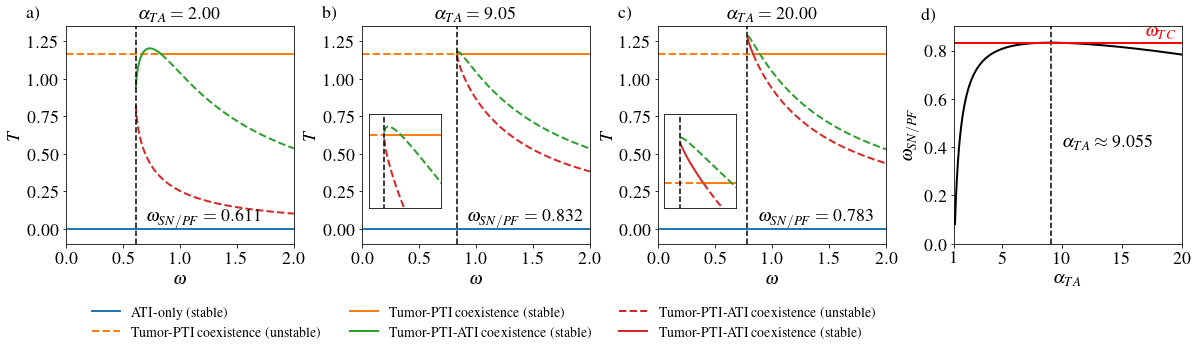

In [12]:
f, ax = plt.subplots(1,4,figsize=(20,4))

labels = [r'a)',r'b)',r'c)']
alphaTA_vals = [2, alphaAT_PF, 20]
omega_SN_indices = [50,472,999]
for n, bif_high_kill in enumerate(bif_high_kills):
    ax[n].plot(bif_high_kill['A']['N'][:,0],bif_high_kill['A']['N'][:,1],c='C0',lw=2)
    ax[n].plot(bif_high_kill['TP']['N'][:,0],(1+np.log(1 - bif_high_kill['TP']['stable'][:,1])) * bif_high_kill['TP']['N'][:,1],'--',c='C1',lw=2)
    ax[n].plot(bif_high_kill['TP']['N'][:,0],(1+np.log(bif_high_kill['TP']['stable'][:,1])) * bif_high_kill['TP']['N'][:,1],c='C1',lw=2)

    ax[n].plot(bif_high_kill['TPA1']['N'][:,0],(1+np.log(1 - bif_high_kill['TPA1']['stable'][:,1])) * bif_high_kill['TPA1']['N'][:,1],'--',c='C2',lw=2)
    ax[n].plot(bif_high_kill['TPA1']['N'][:,0],(1+np.log(bif_high_kill['TPA1']['stable'][:,1])) * bif_high_kill['TPA1']['N'][:,1],c='C2',lw=2)

    ax[n].plot(bif_high_kill['TPA2']['N'][:,0],(1+np.log(1 - bif_high_kill['TPA2']['stable'][:,1])) * bif_high_kill['TPA2']['N'][:,1],'--',c='C3',lw=2)
    ax[n].plot(bif_high_kill['TPA2']['N'][:,0],(1+np.log(bif_high_kill['TPA2']['stable'][:,1])) * bif_high_kill['TPA2']['N'][:,1],c='C3',lw=2)

    ax[n].plot([omega_bifurcations[omega_SN_indices[n],1],omega_bifurcations[omega_SN_indices[n],1]],[-.1,1.4],'--',c='k')
    ax[n].text(omega_bifurcations[omega_SN_indices[n],1]+.1,.05,r'$\omega_{SN/PF}=%0.3f$'%omega_bifurcations[omega_SN_indices[n],1])
    
    ax[n].set_xlim([0,2])
    ax[n].set_ylim([-.1,1.35])
    ax[n].set_xlabel(r'$\omega$')
    ax[n].set_ylabel(r'$T$')
    #ax[n].text(-.5,1.3,labels[n])
    ax[n].text(-.35,1.4,labels[n])
    ax[n].text(1,1.4,r'$\alpha_{TA}=%0.2f$'%alphaTA_vals[n],horizontalalignment='center')
    if (n == 1):
        ax_inset1 = f.add_axes([0.335, 0.25, 0.05, 0.325])
        ax_inset1.set_xticks([])
        ax_inset1.set_yticks([])
        
        ax_inset1.plot(bif_high_kill['A']['N'][:,0],bif_high_kill['A']['N'][:,1],c='C0',lw=2)
        ax_inset1.plot(bif_high_kill['TP']['N'][:,0],(1+np.log(1 - bif_high_kill['TP']['stable'][:,1])) * bif_high_kill['TP']['N'][:,1],'--',c='C1',lw=2)
        ax_inset1.plot(bif_high_kill['TP']['N'][:,0],(1+np.log(bif_high_kill['TP']['stable'][:,1])) * bif_high_kill['TP']['N'][:,1],c='C1',lw=2)
        ax_inset1.plot(bif_high_kill['TPA1']['N'][:,0],(1+np.log(1 - bif_high_kill['TPA1']['stable'][:,1])) * bif_high_kill['TPA1']['N'][:,1],'--',c='C2',lw=2)
        ax_inset1.plot(bif_high_kill['TPA1']['N'][:,0],(1+np.log(bif_high_kill['TPA1']['stable'][:,1])) * bif_high_kill['TPA1']['N'][:,1],c='C2',lw=2)
        ax_inset1.plot(bif_high_kill['TPA2']['N'][:,0],(1+np.log(1 - bif_high_kill['TPA2']['stable'][:,1])) * bif_high_kill['TPA2']['N'][:,1],'--',c='C3',lw=2)
        ax_inset1.plot(bif_high_kill['TPA2']['N'][:,0],(1+np.log(bif_high_kill['TPA2']['stable'][:,1])) * bif_high_kill['TPA2']['N'][:,1],c='C3',lw=2)
        ax_inset1.plot([omega_bifurcations[omega_SN_indices[n],1],omega_bifurcations[omega_SN_indices[n],1]],[-.1,1.4],'--',c='k')
    
        ax_inset1.set_xlim([.8,.95])
        ax_inset1.set_ylim([1.05,1.2])
    elif (n == 2):
        ax_inset2 = f.add_axes([0.54, 0.25, 0.05, 0.325])
        ax_inset2.set_xticks([])
        ax_inset2.set_yticks([])
        
        ax_inset2.plot(bif_high_kill['A']['N'][:,0],bif_high_kill['A']['N'][:,1],c='C0',lw=2)
        ax_inset2.plot(bif_high_kill['TP']['N'][:,0],(1+np.log(1 - bif_high_kill['TP']['stable'][:,1])) * bif_high_kill['TP']['N'][:,1],'--',c='C1',lw=2)
        ax_inset2.plot(bif_high_kill['TP']['N'][:,0],(1+np.log(bif_high_kill['TP']['stable'][:,1])) * bif_high_kill['TP']['N'][:,1],c='C1',lw=2)
        ax_inset2.plot(bif_high_kill['TPA1']['N'][:,0],(1+np.log(1 - bif_high_kill['TPA1']['stable'][:,1])) * bif_high_kill['TPA1']['N'][:,1],'--',c='C2',lw=2)
        ax_inset2.plot(bif_high_kill['TPA1']['N'][:,0],(1+np.log(bif_high_kill['TPA1']['stable'][:,1])) * bif_high_kill['TPA1']['N'][:,1],c='C2',lw=2)
        ax_inset2.plot(bif_high_kill['TPA2']['N'][:,0],(1+np.log(1 - bif_high_kill['TPA2']['stable'][:,1])) * bif_high_kill['TPA2']['N'][:,1],'--',c='C3',lw=2)
        ax_inset2.plot(bif_high_kill['TPA2']['N'][:,0],(1+np.log(bif_high_kill['TPA2']['stable'][:,1])) * bif_high_kill['TPA2']['N'][:,1],c='C3',lw=2)
        ax_inset2.plot([omega_bifurcations[omega_SN_indices[n],1],omega_bifurcations[omega_SN_indices[n],1]],[-.1,1.4],'--',c='k')
    
        ax_inset2.set_xlim([.75,.9])
        ax_inset2.set_ylim([1.1,1.35])
        
ax[3].plot(omega_bifurcations[:,0],omega_bifurcations[:,1],c='k',lw=2)
ax[3].plot([alphaAT_PF,alphaAT_PF],[0,1],'--',c='k')
ax[3].plot([0,20],[omega_max,omega_max],c='red',lw=2)
ax[3].set_xticks([1,5,10,15,20])
ax[3].set_xlim([1,20])
ax[3].set_ylim([0,.9])
ax[3].set_xlabel(r'$\alpha_{TA}$')
ax[3].set_ylabel(r'$\omega_{SN/PF}$')
ax[3].text(17,.86,r'$\omega_{TC}$',c='r')
#ax[3].text(-2,.875,r'\textbf{D}')
ax[3].text(-1.75,.925,r'd)')
ax[3].text(alphaAT_PF+1,.4,r'$\alpha_{TA}\approx{}%0.3f$'%alphaAT_PF)

f.subplots_adjust(wspace=.3)
legend_elements = [mpl.lines.Line2D([0], [0], color='C0', lw=2, label=r'ATI-only (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C1', lw=2, label=r'Tumor-PTI coexistence (unstable)'),\
                   mpl.lines.Line2D([0], [0], color='C1', lw=2, label=r'Tumor-PTI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], color='C2', lw=2, label=r'Tumor-PTI-ATI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C3', lw=2, label=r'Tumor-PTI-ATI coexistence (unstable)'),\
                   mpl.lines.Line2D([0], [0], color='C3', lw=2, label=r'Tumor-PTI-ATI coexistence (stable)')]
f.legend(handles=legend_elements,frameon=False,loc='lower center',bbox_to_anchor=[0.415, -.25],ncol=3,fontsize=14)

plt.savefig('omega_bifurcation_locations.png',dpi=300,bbox_inches='tight',facecolor='w')

# Produce Figure 4

In [13]:
def trajectory_fates(params, varied_param, vary_vals, tol_converge=1e-5, tol_dist=1e-4, initial_points = np.linspace(0,1.5,num=15), T_int = 200, iter_max = 10):
    results = {'param':varied_param,'data':{val:{} for val in vary_vals}}
    n = 0
    N = len(vary_vals)
    for val in vary_vals:
        params[varied_param] = val
        sols = all_solutions(params)
        
        X =  [[0,0,0],\
               sols['T']['N'][0],\
               sols['A']['N'][0],\
               sols['TP']['N'][0]]
        if ('TPA' in sols.keys()) and (len(sols['TPA']['N']) > 0):
            X.append(sols['TPA']['N'])
        X = np.vstack(X)
        
        trajs = []
        for x in initial_points:
            for y in initial_points:
                for z in initial_points:
                    ode = integrate.solve_ivp(lambda t,N: ode_model(N,params),[0,T_int],np.array([x,y,z]))
                    temp = np.copy(ode.y)
                    n_iter = 0
                    while (np.sum((temp[:,-1] - temp[:,-2])**2) > tol_converge) \
                            or (np.sum((temp[:,-1] - X)**2,axis=1).min() > tol_dist):
                        ode = integrate.solve_ivp(lambda t,N: ode_model(N,params),[0,T_int],temp[:,-1])
                        temp = np.hstack([temp, ode.y[:,1:]])
                        n_iter += 1
                        if n_iter > iter_max:
                            print("Convergence failed.")
                            return temp
                            
                    trajs.append(temp[:,[0,-1]])
            
        fates = []
        for traj in trajs:
            D = np.sum((traj[:,-1] - X)**2,axis=1)
            if D.min() < tol_dist:
                fates.append(list(traj[:,0]) + [np.argmin(D)])
            else:
                print("Uh oh")
                return X, traj, params
                #raise ValueError("It doesn't look like all trajectories converged: $\log_{10}(d_{min})=%0.2f>%0.2f$"%(np.log10(D.min()),np.log10(tol_dist)))
                
        results['data'][val]['X'] = X
        results['data'][val]['fates'] = fates
        
        n += 1
        print(f"{n} / {N} complete",end='\r')
        
    return results

In [14]:
def produce_decision_curves(fate_results, omega, A_levels):
    fate_array = np.array(fate_results['data'][omega]['fates'])
    
    curves = {}
    
    X_color = ['k','C5','C0','C1','C2','C3']
    for A_level in A_levels:
        A = fate_array[np.abs(fate_array[:,2] - A_level).argmin()][2]
        fates_slice = fate_array[fate_array[:,2] == A]
        
        slice_colors = []
        for i in fates_slice[:,3]:
            if X_color[int(i)] == 'C3':
                slice_colors.append('C2')
            else:
                slice_colors.append(X_color[int(i)])
                
        blue = fates_slice[np.array(slice_colors) == 'C0']
        green = fates_slice[np.array(slice_colors) == 'C2']
        orange = fates_slice[np.array(slice_colors) == 'C1']
        max_T = blue[:,0].max()
        if (np.unique(green[:,0]).shape[0] > 2) and (np.unique(blue[:,0]).shape[0] > 2):
            min_T = green[:,0].min()
        elif (np.unique(orange[:,0]).shape[0] > 2) and (np.unique(blue[:,0]).shape[0] > 2):
            min_T = orange[:,0].min()
        else:
            continue
        
        smv_class = svm.SVC(kernel='poly')
        smv_class.fit(fates_slice[:,:2],slice_colors)

        decision_curve_slice = []
        for x in np.linspace(min_T,max_T):
            F = lambda y: smv_class.decision_function(np.array([[x,y]]))
            if np.sign(F(0)) == np.sign(F(1.5)):
                continue
            else:
                y = optimize.root_scalar(F,bracket=[-.1,1.6]).root
                decision_curve_slice.append([x,y])
        if len(decision_curve_slice) == 0:
            continue
        else:
            decision_curve_slice = np.vstack(decision_curve_slice)
            curves[A] = decision_curve_slice
        
    return curves

In [15]:
params_example = {}
params_example['rT'] = 1
params_example['KT'] = 1
params_example['dP'] = 1
params_example['rA'] = 1
params_example['KA'] = 1
params_example['alphaTP'] = .95
params_example['alphaTA'] = 1.5
params_example['alphaPT'] = .15
params_example['alphaAT'] = .05
params_example['alphaAP'] = .5
params_example['omega'] = 0

omega_vals_fates = [.4,.456,.5,.6,.7,.8,.9,1.]

fate_results = trajectory_fates(params_example,'omega',omega_vals_fates,tol_converge=1e-4,tol_dist=1e-2,T_int=200)

In [16]:
decision_curves2 = produce_decision_curves(fate_results, omega_vals_fates[1], np.linspace(.1,1.4,num=20))
decision_curves3 = produce_decision_curves(fate_results, omega_vals_fates[2], np.linspace(.1,1.4,num=20))
decision_curves4 = produce_decision_curves(fate_results, omega_vals_fates[3], np.linspace(.1,1.4,num=20))
decision_curves5 = produce_decision_curves(fate_results, omega_vals_fates[4], np.linspace(.1,1.4,num=20))
decision_curves6 = produce_decision_curves(fate_results, omega_vals_fates[5], np.linspace(.1,1.4,num=20))
decision_curves7 = produce_decision_curves(fate_results, omega_vals_fates[6], np.linspace(.1,1.4,num=20))
decision_curves8 = produce_decision_curves(fate_results, omega_vals_fates[7], np.linspace(.1,1.4,num=20))

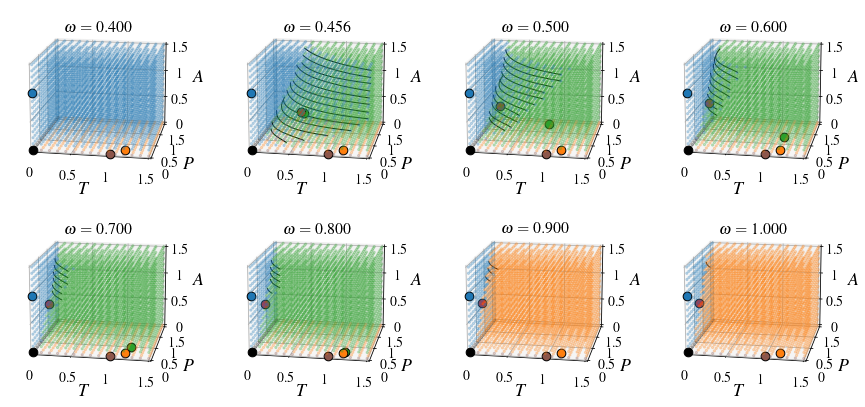

In [17]:
fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(241,projection='3d')
ax2 = fig.add_subplot(242,projection='3d')
ax3 = fig.add_subplot(243,projection='3d')
ax4 = fig.add_subplot(244,projection='3d')
ax5 = fig.add_subplot(245,projection='3d')
ax6 = fig.add_subplot(246,projection='3d')
ax7 = fig.add_subplot(247,projection='3d')
ax8 = fig.add_subplot(248,projection='3d')
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

X_color = ['k','C5','C0','C1','C2','C3']

###

for n, ax in enumerate(axes):
    ax = axes[n]
    X = fate_results['data'][omega_vals_fates[n]]['X']
    fates = np.array(fate_results['data'][omega_vals_fates[n]]['fates'])
    
    ax.scatter(X[0,0],X[0,1],X[0,2],c='k',s=75,edgecolors='k')
    ax.scatter(X[1,0],X[1,1],X[1,2],c='C5',s=75,edgecolors='k')
    ax.scatter(X[2,0],X[2,1],X[2,2],c='C0',s=75,edgecolors='k')
    ax.scatter(X[3,0],X[3,1],X[3,2],c='C1',s=75,edgecolors='k')
    if X.shape[0] == 5:
        if np.all(X[4] >= 0):
            ax.scatter(X[4,0],X[4,1],X[4,2],c='C2',s=75,edgecolors='k')
    elif X.shape[0] == 6:
        if np.all(X[4] >= 0):
            ax.scatter(X[4,0],X[4,1],X[4,2],c='C2',s=75,edgecolors='k')
        if np.all(X[5] >= 0):
            ax.scatter(X[5,0],X[5,1],X[5,2],c='C3',s=75,edgecolors='k')

    fate_colors = []
    for fate in fates:
        if X_color[int(fate[3])] == 'C3':
            fate_colors.append('C2')
        else:
            fate_colors.append(X_color[int(fate[3])])
    
    ax.scatter(fates[:,0],fates[:,1],fates[:,2],c=fate_colors,s=5,alpha=.25)

    ax.set_xlim([0,1.5])
    ax.set_ylim([0,1.5])
    ax.set_zlim([0,1.5])
    ax.set_xticks([0,.5,1,1.5])
    ax.set_xticklabels([0,.5,1,1.5],fontsize=14)
    ax.set_yticks([0,.5,1,1.5])
    ax.set_yticklabels([0,.5,1,1.5],fontsize=14)
    ax.set_zticks([0,.5,1,1.5])
    ax.set_zticklabels([0,.5,1,1.5],fontsize=14)
    ax.set_xlabel(r'$T$')
    ax.set_ylabel(r'$P$')
    ax.set_zlabel(r'$A$')
    ax.view_init(15,-80)
    title = ax.set_title(r'$\omega=%0.3f$'%omega_vals_fates[n],fontsize=16, y=1.0, pad=-10)

dc_list = [decision_curves2,decision_curves3,decision_curves4,decision_curves5,decision_curves6,decision_curves7,decision_curves8]
for n in range(1,8):
    dc = dc_list[n-1]
    for A_level in dc.keys():
        axes[n].plot(dc[A_level][:,0],dc[A_level][:,1],dc[A_level][:,0].shape[0]*[A_level],c='k',lw=1)
        
fig.subplots_adjust(hspace=-.55)

plt.savefig('basins_of_attraction_bifurcation.png',dpi=300,bbox_inches='tight',facecolor='w')

# Produce Figure 5 (alternate models)

In [18]:
def ode_model_alternate(N, params, P_self_lim = True, P_helped_by_T = True, A_external = False):   
    T, P, A = N
    rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega\
    = [params[key] for key in 'rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega'.split(', ')]
    
    dTdt = T * (rT - (rT / KT) * T + alphaTP * P - alphaTA * A)
    
    P_term = 0
    if P_self_lim == True:
        P_term += - dP * P
    elif P_self_lim == False:
        P_term += - dP
    if P_helped_by_T == True:
        P_term += alphaPT * T
    dPdt = P * P_term + omega * A * T
    
    if A_external == False:
        dAdt = A * (rA - (rA / KA) * A + alphaAT * T - alphaAP * P) - omega * A * T
    else:
        dAdt = rA + A * (- (rA / KA) + alphaAT * T - alphaAP * P) - omega * A * T
    
    derivs = np.array([dTdt, dPdt, dAdt])
    
    return derivs

In [19]:
def Jacobian_alternate(N, params, P_self_lim = True, P_helped_by_T = True, A_external = False):   
    T, P, A = N
    rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega\
    = [params[key] for key in 'rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega'.split(', ')]
        
    if A_external == False:
        if (P_self_lim == True) and (P_helped_by_T == True):
            J = np.array([[rT - 2 * (rT / KT) * T + alphaTP * P - alphaTA * A, alphaTP * T, -alphaTA * T],\
                          [alphaPT * P + omega * A, - 2 * dP * P + alphaPT * T, omega * T],\
                          [(alphaAT - omega) * A, -alphaAP * A, rA - 2 * (rA / KA) * A + (alphaAT - omega) * T - alphaAP * P]])
            
        elif (P_self_lim == False) and (P_helped_by_T == True):
            J = np.array([[rT - 2 * (rT / KT) * T + alphaTP * P - alphaTA * A, alphaTP * T, -alphaTA * T],\
                          [alphaPT * P + omega * A, - dP + alphaPT * T, omega * T],\
                          [(alphaAT - omega) * A, -alphaAP * A, rA - 2 * (rA / KA) * A + (alphaAT - omega) * T - alphaAP * P]])
            
        elif (P_self_lim == True) and (P_helped_by_T == False):
            J = np.array([[rT - 2 * (rT / KT) * T + alphaTP * P - alphaTA * A, alphaTP * T, -alphaTA * T],\
                          [omega * A, - 2 * dP * P, omega * T],\
                          [(alphaAT - omega) * A, -alphaAP * A, rA - 2 * (rA / KA) * A + (alphaAT - omega) * T - alphaAP * P]])
            
        elif (P_self_lim == False) and (P_helped_by_T == False):
            J = np.array([[rT - 2 * (rT / KT) * T + alphaTP * P - alphaTA * A, alphaTP * T, -alphaTA * T],\
                          [omega * A, - dP, omega * T],\
                          [(alphaAT - omega) * A, -alphaAP * A, rA - 2 * (rA / KA) * A + (alphaAT - omega) * T - alphaAP * P]])
        
    elif A_external == True:
        if (P_self_lim == True) and (P_helped_by_T == True):
            J = np.array([[rT - 2 * (rT / KT) * T + alphaTP * P - alphaTA * A, alphaTP * T, -alphaTA * T],\
                          [alphaPT * P + omega * A, - 2 * dP * P + alphaPT * T, omega * T],\
                          [(alphaAT - omega) * A, -alphaAP * A, - (rA / KA) + (alphaAT - omega) * T - alphaAP * P]])
            
        elif (P_self_lim == False) and (P_helped_by_T == True):
            J = np.array([[rT - 2 * (rT / KT) * T + alphaTP * P - alphaTA * A, alphaTP * T, -alphaTA * T],\
                          [alphaPT * P + omega * A, - dP + alphaPT * T, omega * T],\
                          [(alphaAT - omega) * A, -alphaAP * A, - (rA / KA) + (alphaAT - omega) * T - alphaAP * P]])
            
        elif (P_self_lim == True) and (P_helped_by_T == False):
            J = np.array([[rT - 2 * (rT / KT) * T + alphaTP * P - alphaTA * A, alphaTP * T, -alphaTA * T],\
                          [omega * A, - 2 * dP * P, omega * T],\
                          [(alphaAT - omega) * A, -alphaAP * A, - (rA / KA) + (alphaAT - omega) * T - alphaAP * P]])
            
        elif (P_self_lim == False) and (P_helped_by_T == False):
            J = np.array([[rT - 2 * (rT / KT) * T + alphaTP * P - alphaTA * A, alphaTP * T, -alphaTA * T],\
                          [omega * A, - dP, omega * T],\
                          [(alphaAT - omega) * A, -alphaAP * A, - (rA / KA) + (alphaAT - omega) * T - alphaAP * P]])
        
    return J

In [20]:
def all_solutions_alternate(params, check = True, tol = 1e-7, P_self_lim = True, P_helped_by_T = True, A_external = False):
    rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega\
    = [params[key] for key in 'rT, KT, dP, rA, KA, alphaTP, alphaTA, alphaPT, alphaAT, alphaAP, omega'.split(', ')]
    
    def check_stable_feasible(N, params):
        if np.any(np.isnan(N)):
            return np.nan, np.nan
        if np.inf in N:
            return np.nan, np.nan
            
        J = Jacobian_alternate(N, params, P_self_lim = P_self_lim, P_helped_by_T = P_helped_by_T, A_external = A_external)
        l, v = np.linalg.eig(J)
        stable = np.all(np.real(l) <= 0)
        feasible = np.all(N >= 0)
        return stable, feasible
    
    solutions = {}
    
    # I) Tumor-only
    
    solutions['T'] = {}
    if A_external == False:
        N = np.array([KT, 0 , 0])
        stable, feasible = check_stable_feasible(N, params)
    
        solutions['T']['N'] = [N]
        solutions['T']['stable'] = [stable]
        solutions['T']['feasible'] = [feasible]
    else:
        solutions['T']['N'] = [np.array([np.nan,np.nan,np.nan])]
        solutions['T']['stable'] = [np.nan]
        solutions['T']['feasible'] = [np.nan]
    
    # II) ATI-only
    
    solutions['A'] = {}
    
    N = np.array([0, 0 , KA])
    stable, feasible = check_stable_feasible(N, params)
    
    solutions['A']['N'] = [N]
    solutions['A']['stable'] = [stable]
    solutions['A']['feasible'] = [feasible]
    
    # III) Tumor-ATI coexistence
    
    solutions['TA'] = {}
    
    if omega == 0:
        
        OmegaAT = rA + alphaAT * KT
        GammaAA = (rA / KA) + (alphaAT * alphaTA) / (rT / KT)
        N = np.array([KT - (KT * alphaTA / rT) * OmegaAT / GammaAA, 0, OmegaAT / GammaAA])
        stable, feasible = check_stable_feasible(N, params)
    
        solutions['TA']['N'] = [N]
        solutions['TA']['stable'] = [stable]
        solutions['TA']['feasible'] = [feasible]
        
    else:
        solutions['TA']['N'] = [np.array([np.nan,np.nan,np.nan])]
        solutions['TA']['stable'] = [np.nan]
        solutions['TA']['feasible'] = [np.nan]
    
    # IV) Tumor-PTI coexistence
    
    solutions['TP'] = {}
    
    if (A_external == False) and (P_self_lim == False) and (P_helped_by_T == True):
        T = dP / alphaPT
        P = ((dP / alphaPT) / KT - rT) / alphaTP
        A = 0
        N = np.array([T, P, A])
        stable, feasible =  check_stable_feasible(N, params)
        
        solutions['TP']['N'] = [N]
        solutions['TP']['stable'] = [stable]
        solutions['TP']['feasible'] = [feasible]
    
    elif (A_external == False) and (P_self_lim == True) and (P_helped_by_T == True):
        GammaTT = (rT / KT) - (alphaTP * alphaPT / dP)
        N = np.array([rT / GammaTT, (alphaPT / dP) * (rT / GammaTT), 0])
        stable, feasible = check_stable_feasible(N, params)
    
        solutions['TP']['N'] = [N]
        solutions['TP']['stable'] = [stable]
        solutions['TP']['feasible'] = [feasible]
        
    else:    
        solutions['TP']['N'] = [np.array([np.nan,np.nan,np.nan])]
        solutions['TP']['stable'] = [np.nan]
        solutions['TP']['feasible'] = [np.nan]
    
    # Tumor-PTI-ATI coexistence
    
    solutions['TPA'] = {}
    
    if A_external == False:
        if (P_self_lim == True) and (P_helped_by_T == True):
            C1 = (rA * (rT / KT) + rT * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
            C2 = (alphaAP * (rT / KT) - alphaTP * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
            C3 = alphaTP * KT / rT
            C4 = alphaTA * KT / rT
            a = (C3 + C2 * C4) * (alphaPT - omega * C2) - dP
            b = (KT - C1 * C4) * (alphaPT - omega * C2) + omega * C1 * (C3 + C2 * C4) 
            c = omega * C1 * (KT - C1 * C4)
        
        elif (P_self_lim == False) and (P_helped_by_T == True):
            C1 = (rA * (rT / KT) + rT * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
            C2 = (alphaAP * (rT / KT) - alphaTP * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
            C3 = alphaTP * KT / rT
            C4 = alphaTA * KT / rT
            a = (C3 + C2 * C4) * (alphaPT - omega * C2)
            b = (KT - C1 * C4) * (alphaPT - omega * C2) + omega * C1 * (C3 + C2 * C4) - dP
            c = omega * C1 * (KT - C1 * C4)
            
        elif (P_self_lim == True) and (P_helped_by_T == False):
            C1 = (rA * (rT / KT) + rT * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
            C2 = (alphaAP * (rT / KT) - alphaTP * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
            C3 = alphaTP * KT / rT
            C4 = alphaTA * KT / rT
            a = (C3 + C2 * C4) * - omega * C2 - dP
            b = (KT - C1 * C4) * - omega * C2 + omega * C1 * (C3 + C2 * C4) 
            c = omega * C1 * (KT - C1 * C4)
            
        elif (P_self_lim == False) and (P_helped_by_T == False):
            C1 = (rA * (rT / KT) + rT * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
            C2 = (alphaAP * (rT / KT) - alphaTP * (alphaAT - omega)) / ((rA / KA) * (rT / KT) + alphaTA * (alphaAT - omega))
            C3 = alphaTP * KT / rT
            C4 = alphaTA * KT / rT
            a = (C3 + C2 * C4) * - omega * C2 
            b = (KT - C1 * C4) * - omega * C2 + omega * C1 * (C3 + C2 * C4) - dP
            c = omega * C1 * (KT - C1 * C4)
        
        if b ** 2 - 4 * a * c < 0:
        
            solutions['TPA']['N'] = [np.array([np.nan,np.nan,np.nan])]
            solutions['TPA']['stable'] = [np.nan]
            solutions['TPA']['feasible'] = [np.nan]

        elif b ** 2 - 4 * a * c == 0:

            P = - b / (2 * a)
            A = C1 - C2 * P
            T = KT + C3 * P - C4 * A
            N = np.array([T, P, A])
            stable, feasible = check_stable_feasible(N, params)

            solutions['TPA']['N'] = [N]
            solutions['TPA']['stable'] = [stable]
            solutions['TPA']['feasible'] = [feasible]

        elif b ** 2 - 4 * a * c > 0:

            P1 = (- b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
            A1 = C1 - C2 * P1
            T1 = KT + C3 * P1 - C4 * A1
            N1 = np.array([T1, P1, A1])
            stable1, feasible1 = check_stable_feasible(N1, params)

            P2 = (- b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
            A2 = C1 - C2 * P2
            T2 = KT + C3 * P2 - C4 * A2
            N2 = np.array([T2, P2, A2])
            stable2, feasible2 = check_stable_feasible(N2, params)

            if (N1[0] >= N2[0]):
                solutions['TPA']['N'] = [N1, N2]
                solutions['TPA']['stable'] = [stable1, stable2]
                solutions['TPA']['feasible'] = [feasible1, feasible2]
            elif (N1[0] < N2[0]):
                solutions['TPA']['N'] = [N2, N1]
                solutions['TPA']['stable'] = [stable2, stable1]
                solutions['TPA']['feasible'] = [feasible2, feasible1]
        
        if len(solutions['TPA'].keys()) == 0:
            solutions['TPA']['N'] = [np.array([np.nan,np.nan,np.nan])]
            solutions['TPA']['stable'] = [np.nan]
            solutions['TPA']['feasible'] = [np.nan]
        
    elif A_external == True:
        
        X = (alphaTP * KT) / rT
        Y = - (alphaTA * KT) / rT
        
        C0 = (KT - rA / (KA * (alphaAT - omega))) / (alphaAP / (alphaAT - omega) - (alphaTP * KT) / rT)
        C1 = (alphaTA * KT / rT) / (alphaAP / (alphaAT - omega) - (alphaTP * KT) / rT)
        Cm1 = (rA / (alphaAT - omega)) / (alphaAP / (alphaAT - omega) - (alphaTP * KT) / rT)
        kt, x, c0, c1, a, cm1, y, aPT, o, dp = sympy.symbols("kt x c0 c1 a cm1 y aPT o dp")
        
        if (P_self_lim == True) and (P_helped_by_T == True):
            
            expr1 = (kt + x * (c0 - c1 * a + cm1 / a) + y * a) * (aPT * (c0 - c1 * a + cm1 / a) + o * a) - dp * (c0 - c1 * a + cm1 / a)**2
            expression = a**2 * (sympy.simplify(expr1))
            coeffs_list = sympy.Poly(sympy.collect(expression.expand(),a),a).coeffs()[::-1]

            coeffs = []
            for c in coeffs_list:
                coeff = c.subs([(var,val) for var,val in zip([kt, x, c0, c1, cm1, y, aPT, o, dp],[KT, X, C0, C1, Cm1, Y, alphaPT, omega, dP])])
                coeffs.append(float(coeff))
                
        elif (P_self_lim == False) and (P_helped_by_T == True):
            expr1 = (kt + x * (c0 - c1 * a + cm1 / a) + y * a) * (aPT * (c0 - c1 * a + cm1 / a) + o * a) - dp * (c0 - c1 * a + cm1 / a)
            expression = a**2 * (sympy.simplify(expr1))
            coeffs_list = sympy.Poly(sympy.collect(expression.expand(),a),a).coeffs()[::-1]

            coeffs = []
            for c in coeffs_list:
                coeff = c.subs([(var,val) for var,val in zip([kt, x, c0, c1, cm1, y, aPT, o, dp],[KT, X, C0, C1, Cm1, Y, alphaPT, omega, dP])])
                coeffs.append(float(coeff))
              
        elif (P_self_lim == True) and (P_helped_by_T == False):
            expr1 = (kt + x * (c0 - c1 * a + cm1 / a) + y * a) * o * a - dp * (c0 - c1 * a + cm1 / a)**2
            expression = a**2 * (sympy.simplify(expr1))
            coeffs_list = sympy.Poly(sympy.collect(expression.expand(),a),a).coeffs()[::-1]

            coeffs = []
            for c in coeffs_list:
                coeff = c.subs([(var,val) for var,val in zip([kt, x, c0, c1, cm1, y, aPT, o, dp],[KT, X, C0, C1, Cm1, Y, alphaPT, omega, dP])])
                coeffs.append(float(coeff))
            
        elif (P_self_lim == False) and (P_helped_by_T == False):
            expr1 = (kt + x * (c0 - c1 * a + cm1 / a) + y * a) * o * a - dp * (c0 - c1 * a + cm1 / a)
            expression = a**2 * (sympy.simplify(expr1))
            coeffs_list = sympy.Poly(sympy.collect(expression.expand(),a),a).coeffs()[::-1]

            coeffs = []
            for c in coeffs_list:
                coeff = c.subs([(var,val) for var,val in zip([kt, x, c0, c1, cm1, y, aPT, o, dp],[KT, X, C0, C1, Cm1, Y, alphaPT, omega, dP])])
                coeffs.append(float(coeff))
        
        poly = np.polynomial.Polynomial(coeffs)
        A_all = poly.roots()
        A_all = np.real(A_all[(np.imag(A_all) == 0)])
        
        sols = []
        feas = []
        stab = []
        for A in A_all:
            P = C0 - C1 * A + Cm1 / A
            T = KT + (alphaTP * KT / rT) * P - (alphaTA * KT / rT) * A
            #if np.all(np.array([T,P,A]) >= 0):
            sols.append(np.array([T, P, A]))
            stable, feasible = check_stable_feasible(np.array([T, P, A]), params)
            feas.append(feasible)
            stab.append(stable)
        
        if len(sols) == 0:
            sols = [np.array([np.nan, np.nan, np.nan])]
            stab = [np.nan]
            feas = [np.nan]
                                     
        solutions['TPA']['N'] = sols
        solutions['TPA']['stable'] = stab
        solutions['TPA']['feasible'] = feas
        
    # Check consistency of solutions with original equations
    
    if check == True:
        for key in solutions.keys():
            for N in solutions[key]['N']:
                if np.any(np.abs(ode_model_alternate(N, params, P_self_lim = P_self_lim, P_helped_by_T = P_helped_by_T, A_external = A_external)) > tol):
                    print("Warning: Check the %s solution."%key)
    
    return solutions

In [21]:
def bifurcation_alternate(bif_param, bif_param_vals, params, P_self_lim = True, P_helped_by_T = True, A_external = False):
    if bif_param not in params.keys():
        raise ValueError("This is an invalid bifurcation parameter.")
        
    if isinstance(bif_param_vals, list):
        bif_param_vals = np.array(bif_param_vals)
    elif isinstance(bif_param_vals, np.ndarray):
        bif_param_vals = bif_param_vals.flatten()
    else:
        raise ValueError("\'bif_param_vals\' should be a list or numpy array.")
        
    bif_params = {}
    for key in params.keys():
        bif_params[key] = params[key]
    
    results = {}
    results['bifurcation parameter'] = bif_param
    results['bifurcation parameter values'] = bif_param_vals
    results['T'] = {'N':[], 'stable':[], 'feasible':[]}
    results['A'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TA'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TP'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TPA1'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TPA2'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TPA3'] = {'N':[], 'stable':[], 'feasible':[]}
    results['TPA4'] = {'N':[], 'stable':[], 'feasible':[]}
    
    for n, bp in enumerate(bif_param_vals):
        bif_params[bif_param] = bp
        sols = all_solutions_alternate(bif_params, check = False, P_self_lim = P_self_lim, P_helped_by_T = P_helped_by_T, A_external = A_external)
        
        results['T']['N'].append([bp] + list(sols['T']['N'][0]))
        results['T']['stable'].append([bp, sols['T']['stable'][0]])
        results['T']['feasible'].append([bp, sols['T']['feasible'][0]])
        
        results['A']['N'].append([bp] + list(sols['A']['N'][0]))
        results['A']['stable'].append([bp, sols['A']['stable'][0]])
        results['A']['feasible'].append([bp, sols['A']['feasible'][0]])
            
        if len(sols['TA']['N']) == 0:
            results['TA']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TA']['stable'].append([bp, np.nan])
            results['TA']['feasible'].append([bp, np.nan])
        else:
            results['TA']['N'].append([bp] + list(sols['TA']['N'][0]))
            results['TA']['stable'].append([bp, sols['TA']['stable'][0]])
            results['TA']['feasible'].append([bp, sols['TA']['feasible'][0]])
        
        results['TP']['N'].append([bp] + list(sols['TP']['N'][0]))
        results['TP']['stable'].append([bp, sols['TP']['stable'][0]])
        results['TP']['feasible'].append([bp, sols['TP']['feasible'][0]])
        
        if len(sols['TPA']['N']) == 0:
            results['TPA1']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA1']['stable'].append([bp, np.nan])
            results['TPA1']['feasible'].append([bp, np.nan])
            
            results['TPA2']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA2']['stable'].append([bp, np.nan])
            results['TPA2']['feasible'].append([bp, np.nan])
            
            results['TPA3']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA3']['stable'].append([bp, np.nan])
            results['TPA3']['feasible'].append([bp, np.nan])
            
            results['TPA4']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA4']['stable'].append([bp, np.nan])
            results['TPA4']['feasible'].append([bp, np.nan])
            
        elif len(sols['TPA']['N']) == 1:
            results['TPA1']['N'].append([bp] + list(sols['TPA']['N'][0]))
            results['TPA1']['stable'].append([bp, sols['TPA']['stable'][0]])
            results['TPA1']['feasible'].append([bp, sols['TPA']['feasible'][0]])
            
            results['TPA2']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA2']['stable'].append([bp, np.nan])
            results['TPA2']['feasible'].append([bp, np.nan])
            
            results['TPA3']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA3']['stable'].append([bp, np.nan])
            results['TPA3']['feasible'].append([bp, np.nan])
            
            results['TPA4']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA4']['stable'].append([bp, np.nan])
            results['TPA4']['feasible'].append([bp, np.nan])
            
        elif len(sols['TPA']['N']) == 2:
            s1 = 0
            s2 = 1
            
            results['TPA1']['N'].append([bp] + list(sols['TPA']['N'][s1]))
            results['TPA1']['stable'].append([bp, sols['TPA']['stable'][s1]])
            results['TPA1']['feasible'].append([bp, sols['TPA']['feasible'][s1]])
            
            results['TPA2']['N'].append([bp] + list(sols['TPA']['N'][s2]))
            results['TPA2']['stable'].append([bp, sols['TPA']['stable'][s2]])
            results['TPA2']['feasible'].append([bp, sols['TPA']['feasible'][s2]])
            
            results['TPA3']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA3']['stable'].append([bp, np.nan])
            results['TPA3']['feasible'].append([bp, np.nan])
            
            results['TPA4']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA4']['stable'].append([bp, np.nan])
            results['TPA4']['feasible'].append([bp, np.nan])

        elif len(sols['TPA']['N']) == 3:
            s1 = 0
            s2 = 1
            s3 = 2
            
            results['TPA1']['N'].append([bp] + list(sols['TPA']['N'][s1]))
            results['TPA1']['stable'].append([bp, sols['TPA']['stable'][s1]])
            results['TPA1']['feasible'].append([bp, sols['TPA']['feasible'][s1]])
            
            results['TPA2']['N'].append([bp] + list(sols['TPA']['N'][s2]))
            results['TPA2']['stable'].append([bp, sols['TPA']['stable'][s2]])
            results['TPA2']['feasible'].append([bp, sols['TPA']['feasible'][s2]])
            
            results['TPA3']['N'].append([bp] + list(sols['TPA']['N'][s3]))
            results['TPA3']['stable'].append([bp, sols['TPA']['stable'][s3]])
            results['TPA3']['feasible'].append([bp, sols['TPA']['feasible'][s3]])
            
            results['TPA4']['N'].append([bp, np.nan, np.nan, np.nan])
            results['TPA4']['stable'].append([bp, np.nan])
            results['TPA4']['feasible'].append([bp, np.nan])
            
        elif len(sols['TPA']['N']) == 4:
            s1 = 0
            s2 = 1
            s3 = 2
            s4 = 3
            
            results['TPA1']['N'].append([bp] + list(sols['TPA']['N'][s1]))
            results['TPA1']['stable'].append([bp, sols['TPA']['stable'][s1]])
            results['TPA1']['feasible'].append([bp, sols['TPA']['feasible'][s1]])
            
            results['TPA2']['N'].append([bp] + list(sols['TPA']['N'][s2]))
            results['TPA2']['stable'].append([bp, sols['TPA']['stable'][s2]])
            results['TPA2']['feasible'].append([bp, sols['TPA']['feasible'][s2]])
            
            results['TPA3']['N'].append([bp] + list(sols['TPA']['N'][s3]))
            results['TPA3']['stable'].append([bp, sols['TPA']['stable'][s3]])
            results['TPA3']['feasible'].append([bp, sols['TPA']['feasible'][s3]])
            
            results['TPA4']['N'].append([bp] + list(sols['TPA']['N'][s4]))
            results['TPA4']['stable'].append([bp, sols['TPA']['stable'][s4]])
            results['TPA4']['feasible'].append([bp, sols['TPA']['feasible'][s4]])
    
    for state in ['T', 'A', 'TA', 'TP', 'TPA1', 'TPA2', 'TPA3', 'TPA4']:
        results[state]['N'] = np.vstack(results[state]['N'])
        results[state]['stable'] = np.vstack(results[state]['stable'])
        results[state]['feasible'] = np.vstack(results[state]['feasible'])
        
    return results

In [22]:
params_example = {}
params_example['rT'] = 1
params_example['KT'] = 1
params_example['dP'] = 1
params_example['rA'] = 1
params_example['KA'] = 1
params_example['alphaTP'] = .95
params_example['alphaTA'] = 1.5
params_example['alphaPT'] = .15
params_example['alphaAT'] = .05
params_example['alphaAP'] = .5
params_example['omega'] = 0

alternate_model_results = []

bif_param_vals = np.linspace(0,5,num=500)
for cond1 in [True, False]:
    for cond2 in [True, False]:
        for cond3 in [False, True]:
            alternate_model = {}
            bif_results_alt = bifurcation_alternate('omega', bif_param_vals, params_example,P_self_lim=cond1,P_helped_by_T=cond2,A_external=cond3)
            alternate_model['model'] = {'P_self_lim': cond1, 'P_helped_by_T': cond2, 'A_external': cond3}
            alternate_model['results'] = bif_results_alt
            alternate_model_results.append(alternate_model)

/var/folders/h7/hvyr290d0v33xxn2qlq0_rth0000gp/T/ipykernel_78623/2575480282.py:155: RuntimeWarning: invalid value encountered in double_scalars
  P1 = (- b - np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
/var/folders/h7/hvyr290d0v33xxn2qlq0_rth0000gp/T/ipykernel_78623/2575480282.py:161: RuntimeWarning: divide by zero encountered in double_scalars
  P2 = (- b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)


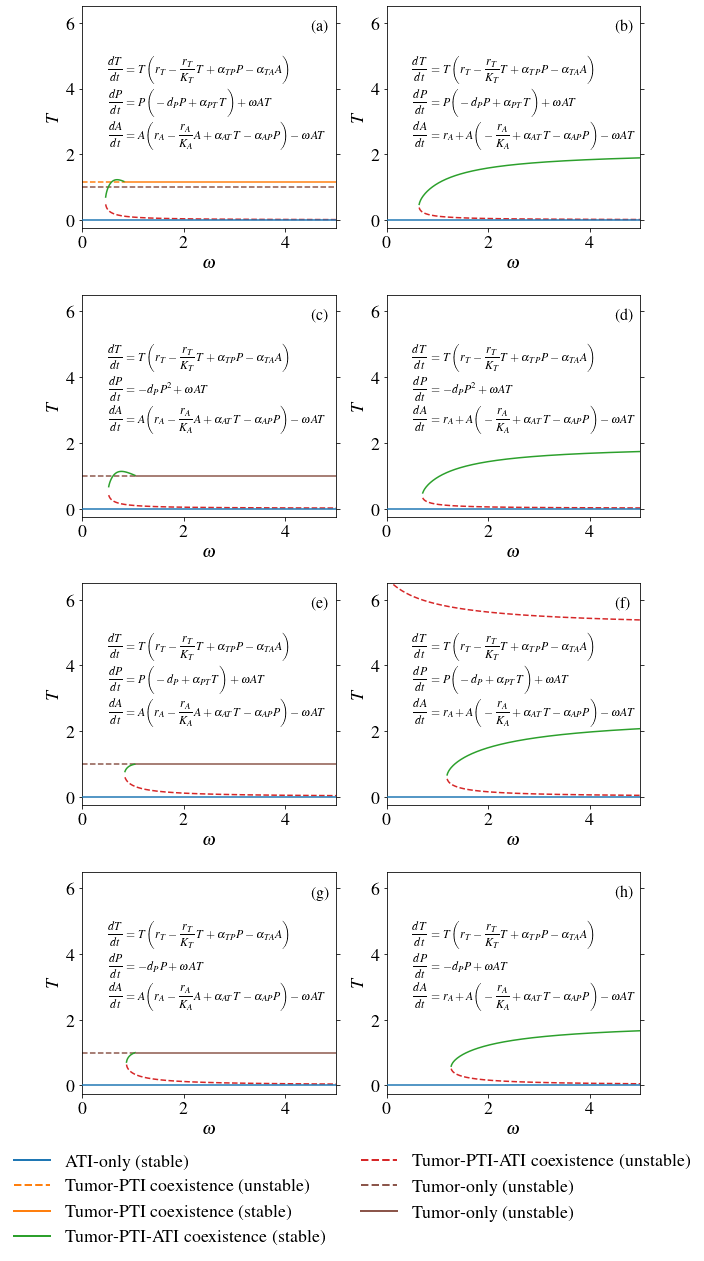

In [23]:
f, ax = plt.subplots(4,2,figsize=(10,20))
C = {'T':'C5','A':'C0','TA':'C6','TP':'C1','TPA1':'C2','TPA2':'C3','TPA3':'C4','TPA4':'C5'}
subplot_labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']

m = 0
for a in ax.flatten():
    bif_results_alt = alternate_model_results[m]['results']
    model = alternate_model_results[m]['model']
    for state_type in ['T','A','TP','TPA1','TPA2','TPA3','TPA4']:
        unstab = np.where((bif_results_alt[state_type]['feasible'][:,1] == 1) * (bif_results_alt[state_type]['stable'][:,1] == 0))[0]
        stab = np.where((bif_results_alt[state_type]['feasible'][:,1] == 1) * (bif_results_alt[state_type]['stable'][:,1] == 1))[0]
        if state_type in ['TPA1','TPA2','TPA3','TPA4']:
            a.plot(bif_results_alt[state_type]['N'][unstab,0],bif_results_alt[state_type]['N'][unstab,1],'--',c=C['TPA2'])
            a.plot(bif_results_alt[state_type]['N'][stab,0],bif_results_alt[state_type]['N'][stab,1],c=C['TPA1'])
        else:
            a.plot(bif_results_alt[state_type]['N'][unstab,0],bif_results_alt[state_type]['N'][unstab,1],'--',c=C[state_type])
            a.plot(bif_results_alt[state_type]['N'][stab,0],bif_results_alt[state_type]['N'][stab,1],c=C[state_type],zorder=10)
    a.set_xlim([0,5])
    a.set_ylim([-.25,6.5])
    a.set_xlabel(r'$\omega$')
    a.set_ylabel(r'$T$')
    a.text(4.5,5.75,r"%s"%subplot_labels[m],fontsize=16)
    a.tick_params(labelleft=True, labelright=False, left=True, right=True)
    Teqn = r'\frac{dT}{dt}&=T\bigg(r_{T}-\frac{r_{T}}{K_{T}}T+\alpha_{TP}P-\alpha_{TA}A\bigg)\\'
    if (model['P_self_lim'] == True) and (model['P_helped_by_T'] == True):
        Peqn = r'\frac{dP}{dt}&=P\bigg(-d_{P}P+\alpha_{PT}T\bigg)+\omega{}AT\\'
    elif (model['P_self_lim'] == True) and (model['P_helped_by_T'] == False):
        Peqn = r'\frac{dP}{dt}&=-d_{P}P^{2}+\omega{}AT\\'
    elif (model['P_self_lim'] == False) and (model['P_helped_by_T'] == True):
        Peqn = r'\frac{dP}{dt}&=P\bigg(-d_{P}+\alpha_{PT}T\bigg)+\omega{}AT\\'
    elif (model['P_self_lim'] == False) and (model['P_helped_by_T'] == False):
        Peqn = r'\frac{dP}{dt}&=-d_{P}P+\omega{}AT\\'
    if model['A_external'] == False:
        Aeqn = r'\frac{dA}{dt}&=A\bigg(r_{A}-\frac{r_{A}}{K_{A}}A+\alpha_{AT}T-\alpha_{AP}P\bigg)-\omega{}AT'
    else:
        Aeqn = r'\frac{dA}{dt}&=r_{A}+A\bigg(-\frac{r_{A}}{K_{A}}+\alpha_{AT}T-\alpha_{AP}P\bigg)-\omega{}AT'
    eqn = r"\begin{align*}%s\end{align*}"%(Teqn+Peqn+Aeqn)
    a.text(.5,4.5,eqn,fontsize=12)
    m += 1

legend_elements = [mpl.lines.Line2D([0], [0], color='C0', lw=2, label=r'ATI-only (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C1', lw=2, label=r'Tumor-PTI coexistence (unstable)'),\
                   mpl.lines.Line2D([0], [0], color='C1', lw=2, label=r'Tumor-PTI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], color='C2', lw=2, label=r'Tumor-PTI-ATI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C3', lw=2, label=r'Tumor-PTI-ATI coexistence (unstable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C5', lw=2, label=r'Tumor-only (unstable)'),\
                   mpl.lines.Line2D([0], [0], color='C5', lw=2, label=r'Tumor-only (unstable)')]
f.legend(handles=legend_elements,frameon=False,loc='lower center',bbox_to_anchor=[0.5, .0075],ncol=2)
f.subplots_adjust(hspace=.3)

plt.savefig('alternate_models_bifurcation_T.png',bbox_inches='tight',dpi=300,facecolor='w')

## Figure 5, but showing P density instead

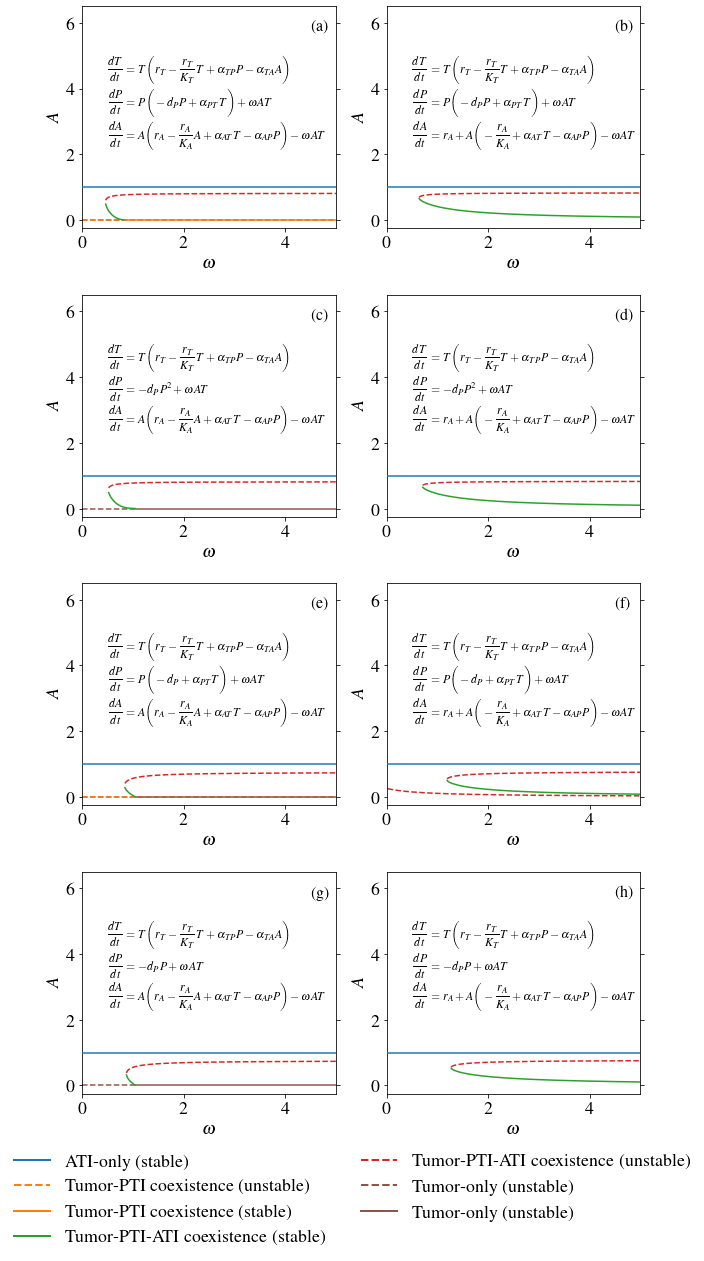

In [24]:
f, ax = plt.subplots(4,2,figsize=(10,20))
C = {'T':'C5','A':'C0','TA':'C6','TP':'C1','TPA1':'C2','TPA2':'C3','TPA3':'C4','TPA4':'C5'}

m = 0
for a in ax.flatten():
    bif_results_alt = alternate_model_results[m]['results']
    model = alternate_model_results[m]['model']
    for state_type in ['T','A','TP','TPA1','TPA2','TPA3','TPA4']:
        unstab = np.where((bif_results_alt[state_type]['feasible'][:,1] == 1) * (bif_results_alt[state_type]['stable'][:,1] == 0))[0]
        stab = np.where((bif_results_alt[state_type]['feasible'][:,1] == 1) * (bif_results_alt[state_type]['stable'][:,1] == 1))[0]
        if state_type in ['TPA1','TPA2','TPA3','TPA4']:
            a.plot(bif_results_alt[state_type]['N'][unstab,0],bif_results_alt[state_type]['N'][unstab,3],'--',c=C['TPA2'])
            a.plot(bif_results_alt[state_type]['N'][stab,0],bif_results_alt[state_type]['N'][stab,3],c=C['TPA1'])
        else:
            a.plot(bif_results_alt[state_type]['N'][unstab,0],bif_results_alt[state_type]['N'][unstab,3],'--',c=C[state_type])
            a.plot(bif_results_alt[state_type]['N'][stab,0],bif_results_alt[state_type]['N'][stab,3],c=C[state_type],zorder=10)
    a.set_xlim([0,5])
    a.set_ylim([-.25,6.5])
    a.set_xlabel(r'$\omega$')
    a.set_ylabel(r'$A$')
    a.text(4.5,5.75,r"%s"%subplot_labels[m],fontsize=16)
    a.tick_params(labelleft=True, labelright=False, left=True, right=True)
    Teqn = r'\frac{dT}{dt}&=T\bigg(r_{T}-\frac{r_{T}}{K_{T}}T+\alpha_{TP}P-\alpha_{TA}A\bigg)\\'
    if (model['P_self_lim'] == True) and (model['P_helped_by_T'] == True):
        Peqn = r'\frac{dP}{dt}&=P\bigg(-d_{P}P+\alpha_{PT}T\bigg)+\omega{}AT\\'
    elif (model['P_self_lim'] == True) and (model['P_helped_by_T'] == False):
        Peqn = r'\frac{dP}{dt}&=-d_{P}P^{2}+\omega{}AT\\'
    elif (model['P_self_lim'] == False) and (model['P_helped_by_T'] == True):
        Peqn = r'\frac{dP}{dt}&=P\bigg(-d_{P}+\alpha_{PT}T\bigg)+\omega{}AT\\'
    elif (model['P_self_lim'] == False) and (model['P_helped_by_T'] == False):
        Peqn = r'\frac{dP}{dt}&=-d_{P}P+\omega{}AT\\'
    if model['A_external'] == False:
        Aeqn = r'\frac{dA}{dt}&=A\bigg(r_{A}-\frac{r_{A}}{K_{A}}A+\alpha_{AT}T-\alpha_{AP}P\bigg)-\omega{}AT'
    else:
        Aeqn = r'\frac{dA}{dt}&=r_{A}+A\bigg(-\frac{r_{A}}{K_{A}}+\alpha_{AT}T-\alpha_{AP}P\bigg)-\omega{}AT'
    eqn = r"\begin{align*}%s\end{align*}"%(Teqn+Peqn+Aeqn)
    a.text(.5,4.5,eqn,fontsize=12)
    m += 1

legend_elements = [mpl.lines.Line2D([0], [0], color='C0', lw=2, label=r'ATI-only (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C1', lw=2, label=r'Tumor-PTI coexistence (unstable)'),\
                   mpl.lines.Line2D([0], [0], color='C1', lw=2, label=r'Tumor-PTI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], color='C2', lw=2, label=r'Tumor-PTI-ATI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C3', lw=2, label=r'Tumor-PTI-ATI coexistence (unstable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C5', lw=2, label=r'Tumor-only (unstable)'),\
                   mpl.lines.Line2D([0], [0], color='C5', lw=2, label=r'Tumor-only (unstable)')]
f.legend(handles=legend_elements,frameon=False,loc='lower center',bbox_to_anchor=[0.5, .0075],ncol=2)
f.subplots_adjust(hspace=.3)

# plt.savefig('alternate_models_bifurcation_A.png',bbox_inches='tight',dpi=300,facecolor='w')

## Figure 5, but showing A density instead

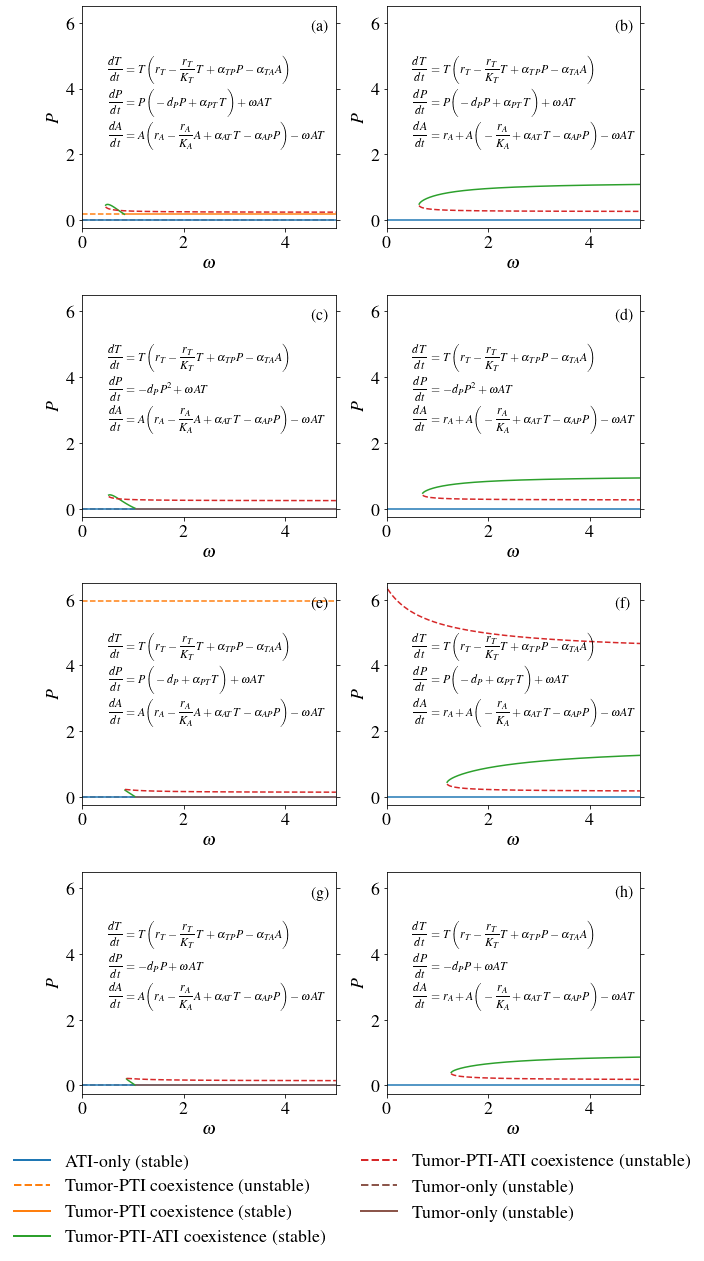

In [25]:
f, ax = plt.subplots(4,2,figsize=(10,20))
C = {'T':'C5','A':'C0','TA':'C6','TP':'C1','TPA1':'C2','TPA2':'C3','TPA3':'C4','TPA4':'C5'}
subplot_labels = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)']

m = 0
for a in ax.flatten():
    bif_results_alt = alternate_model_results[m]['results']
    model = alternate_model_results[m]['model']
    for state_type in ['T','A','TP','TPA1','TPA2','TPA3','TPA4']:
        unstab = np.where((bif_results_alt[state_type]['feasible'][:,1] == 1) * (bif_results_alt[state_type]['stable'][:,1] == 0))[0]
        stab = np.where((bif_results_alt[state_type]['feasible'][:,1] == 1) * (bif_results_alt[state_type]['stable'][:,1] == 1))[0]
        if state_type in ['TPA1','TPA2','TPA3','TPA4']:
            a.plot(bif_results_alt[state_type]['N'][unstab,0],bif_results_alt[state_type]['N'][unstab,2],'--',c=C['TPA2'])
            a.plot(bif_results_alt[state_type]['N'][stab,0],bif_results_alt[state_type]['N'][stab,2],c=C['TPA1'])
        else:
            if state_type == 'T':
                a.plot(bif_results_alt[state_type]['N'][unstab,0],bif_results_alt[state_type]['N'][unstab,2],'--',c=C[state_type])
                a.plot(bif_results_alt[state_type]['N'][stab,0],bif_results_alt[state_type]['N'][stab,2],c=C[state_type],zorder=10)
            else:
                a.plot(bif_results_alt[state_type]['N'][unstab,0],bif_results_alt[state_type]['N'][unstab,2],'--',c=C[state_type])
                a.plot(bif_results_alt[state_type]['N'][stab,0],bif_results_alt[state_type]['N'][stab,2],c=C[state_type])
            
    a.set_xlim([0,5])
    a.set_ylim([-.25,6.5])
    a.set_xlabel(r'$\omega$')
    a.set_ylabel(r'$P$')
    a.text(4.5,5.75,r"%s"%subplot_labels[m],fontsize=16)
    a.tick_params(labelleft=True, labelright=False, left=True, right=True)
    Teqn = r'\frac{dT}{dt}&=T\bigg(r_{T}-\frac{r_{T}}{K_{T}}T+\alpha_{TP}P-\alpha_{TA}A\bigg)\\'
    if (model['P_self_lim'] == True) and (model['P_helped_by_T'] == True):
        Peqn = r'\frac{dP}{dt}&=P\bigg(-d_{P}P+\alpha_{PT}T\bigg)+\omega{}AT\\'
    elif (model['P_self_lim'] == True) and (model['P_helped_by_T'] == False):
        Peqn = r'\frac{dP}{dt}&=-d_{P}P^{2}+\omega{}AT\\'
    elif (model['P_self_lim'] == False) and (model['P_helped_by_T'] == True):
        Peqn = r'\frac{dP}{dt}&=P\bigg(-d_{P}+\alpha_{PT}T\bigg)+\omega{}AT\\'
    elif (model['P_self_lim'] == False) and (model['P_helped_by_T'] == False):
        Peqn = r'\frac{dP}{dt}&=-d_{P}P+\omega{}AT\\'
    if model['A_external'] == False:
        Aeqn = r'\frac{dA}{dt}&=A\bigg(r_{A}-\frac{r_{A}}{K_{A}}A+\alpha_{AT}T-\alpha_{AP}P\bigg)-\omega{}AT'
    else:
        Aeqn = r'\frac{dA}{dt}&=r_{A}+A\bigg(-\frac{r_{A}}{K_{A}}+\alpha_{AT}T-\alpha_{AP}P\bigg)-\omega{}AT'
    eqn = r"\begin{align*}%s\end{align*}"%(Teqn+Peqn+Aeqn)
    a.text(.5,4.5,eqn,fontsize=12)
    m += 1

legend_elements = [mpl.lines.Line2D([0], [0], color='C0', lw=2, label=r'ATI-only (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C1', lw=2, label=r'Tumor-PTI coexistence (unstable)'),\
                   mpl.lines.Line2D([0], [0], color='C1', lw=2, label=r'Tumor-PTI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], color='C2', lw=2, label=r'Tumor-PTI-ATI coexistence (stable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C3', lw=2, label=r'Tumor-PTI-ATI coexistence (unstable)'),\
                   mpl.lines.Line2D([0], [0], linestyle='--', color='C5', lw=2, label=r'Tumor-only (unstable)'),\
                   mpl.lines.Line2D([0], [0], color='C5', lw=2, label=r'Tumor-only (unstable)')]
f.legend(handles=legend_elements,frameon=False,loc='lower center',bbox_to_anchor=[0.5, .0075],ncol=2)
f.subplots_adjust(hspace=.3)

# plt.savefig('alternate_models_bifurcation_P.png',bbox_inches='tight',dpi=300,facecolor='w')